# Topic - BERTopic modelling and Trading Strategies

1. 2019–2022 是近期年份，跟英伟达交易更相关，按月抽样也能保证时间上的代表性，避免主题受到某些年份/季度主导。
2. 主题分类质量不高
	•	大量推文集中在语义稀薄的“泛主题”（如 Topic 0）中；
	•	有效主题（如含情绪词、行业术语、产品事件等）数量少，占比低；
	•	主题关键词不具备显著可交易信息，难以形成明确的多空判断或市场状态。
3. 你已经拥有：
	•	情绪因子；
	•	VIX 情绪恐慌指标；波动因子
	•	技术指标如波动率、成交量、价格动量；技术因子
	•	如果主题分类无法增强这些内容，那保留它只是拖慢效率、增加过拟合风险。
情绪因子
daily average of sentiment_score, topic-wise 情绪（加权 or 选主话题）
主题因子
BERTopic 输出的 dominant topic per day 或主题强度向量
波动因子
vix_open, vix_high, vix_low, vix_close
技术因子
nvda_open, nvda_high, nvda_low, nvda_close, nvda_volume, 可派生指标（return、volatility、RSI、MACD等）

## BERTopic modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import warnings
import os
from tqdm import tqdm
from hdbscan import HDBSCAN
warnings.filterwarnings('ignore')

SAMPLE!!!-->too much data for CPU to handle with in HDBSCAN step...almost 1GB and 500000+ data!

In [2]:
import os
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
from bertopic import BERTopic

# 避免 tokenizer 并行死锁问题
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# 读取数据并筛选2019-2022年数据
df = pd.read_csv("../2_data/financial_tweets_with_sentiment.csv", parse_dates=["Date"])
df = df.dropna(subset=['Processed_Tweet'])  # 去掉空推文
df = df[(df["Date"] >= "2019-01-01") & (df["Date"] <= "2022-12-31")].copy()
df["YearMonth"] = df["Date"].dt.to_period("M")

# 改成直接用全部数据
texts = df["Processed_Tweet"].astype(str).tolist()

# 可选：加进度条显示加载文本的处理
texts = df["Processed_Tweet"].astype(str).tolist()
texts = list(tqdm(texts, desc="Preparing texts"))

# Step 2: 加载嵌入模型 IF YOU DONT HAVE GPU, DROP 'DEVICE=CUDA'
embedding_model = SentenceTransformer("paraphrase-MiniLM-L6-v2")

# Step 3: 定义 BERTopic 模型
hdbscan_model = HDBSCAN(min_cluster_size=30, min_samples=5, metric='euclidean')
topic_model = BERTopic(
    embedding_model=embedding_model,
    language="english",
    calculate_probabilities=False, # initially not produce prob (too slow)
    verbose=True,
    nr_topics = 30
)

# Step 4: 模型训练
topics, _ = topic_model.fit_transform(texts)
df["topic"] = topics

# 检查未分类文本数量（主题 = -1）
n_noise = (df["topic"] == -1).sum()
print(f"❗ 未能归类的推文数量: {n_noise} ({n_noise / len(df):.2%})")

# 过滤无效分类（可选）
df = df[df["topic"] != -1].reset_index(drop=True)

# 保存采样结果
df.to_csv("../2_data/with_BERTtopics.csv", index=False)


Preparing texts: 100%|██████████| 40557/40557 [00:00<00:00, 9744422.71it/s]
2025-05-19 09:46:22,418 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1268 [00:00<?, ?it/s]

2025-05-19 09:49:32,744 - BERTopic - Embedding - Completed ✓
2025-05-19 09:49:32,745 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-19 09:49:54,149 - BERTopic - Dimensionality - Completed ✓
2025-05-19 09:49:54,150 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-19 09:49:58,439 - BERTopic - Cluster - Completed ✓
2025-05-19 09:49:58,440 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-05-19 09:49:58,856 - BERTopic - Representation - Completed ✓
2025-05-19 09:49:58,857 - BERTopic - Topic reduction - Reducing number of topics
2025-05-19 09:49:58,880 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-19 09:49:59,114 - BERTopic - Representation - Completed ✓
2025-05-19 09:49:59,117 - BERTopic - Topic reduction - Reduced number of topics from 401 to 30


❗ 未能归类的推文数量: 19038 (46.94%)


In [3]:
# Step 6: Results Evaluation
import matplotlib.pyplot as plt

# ---- 使用样本数据 df_sample，而不是 df ----

# 1. 查看主题信息（关键词和频率）
print(topic_model.get_topic_info().head(10))     # top 10 topic 概览
print(topic_model.get_topic(0))                  # 查看 topic 0 的关键词列表

# 2. 可视化主题层级（有时帮助判断主题冗余）
fig_hierarchy = topic_model.visualize_hierarchy()
fig_hierarchy.show()

# 3. 可视化主题分布（如主题频率柱状图）
fig_barchart = topic_model.visualize_barchart(top_n_topics=10)
fig_barchart.show()

# 4. 可视化主题点云图（UMAP 降维后）
fig_topics = topic_model.visualize_topics()
fig_topics.show()

# 5. 查看主题数量分布（即每个主题多少条）
topic_counts = df["topic"].value_counts()
print(topic_counts.head(10))

# 6. 可视化主题随时间演化
df["Date"] = pd.to_datetime(df["Date"], errors='coerce')
df_clean = df.dropna(subset=["Date", "Processed_Tweet", "topic"])
docs = df_clean["Processed_Tweet"].tolist()
timestamps = df_clean["Date"].tolist()
topics = df_clean["topic"].tolist()
topics_over_time = topic_model.topics_over_time(docs, timestamps, topics=topics)
fig = topic_model.visualize_topics_over_time(topics_over_time)
fig.show()

# 7. 打印前 5 个主题关键词（可选）
print("\nTop 5 Topics:")
for topic_num in range(5):
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))


# 获取所有主题及关键词
topic_keywords = {}
for topic_num in df["topic"].unique():
    words = topic_model.get_topic(topic_num)
    keywords = [word for word, _ in words[:10]]
    topic_keywords[topic_num] = keywords

# 手动设置 bullish / bearish 关键词库（可扩展）
bullish_words = {"growth", "beat", "record", "strong", "buy", "profit", "boom", "innovation", "optimism"}
bearish_words = {"loss", "fear", "fall", "crash", "bad", "bear", "cut", "warning", "down", "panic"}

# 判断每个主题关键词中正/负情绪词数量
bullish_topics = []
bearish_topics = []

for topic_num, keywords in topic_keywords.items():
    score = sum(kw in bullish_words for kw in keywords) - sum(kw in bearish_words for kw in keywords)
    if score >= 1:
        bullish_topics.append(topic_num)
    elif score <= -1:
        bearish_topics.append(topic_num)

print("🐂 Bullish Topics:", bullish_topics)
print("🐻 Bearish Topics:", bearish_topics)




   Topic  Count                             Name  \
0     -1  19038         -1_nvda_stock_market_amd   
1      0  12117         0_nvda_stock_share_split   
2      1   2840     1_bullish_bear_bearish_green   
3      2   1972         2_trade_amd_stock_market   
4      3   1638     3_upgrad_volum_nvda_downgrad   
5      4   1167      4_elliottwav_updat_box_view   
6      5    329          5_gap_resist_fill_break   
7      6    280  6_paid_strike_sentiment_premium   
8      7    195          7_put_option_volum_bayo   
9      8    116      8_time_trade_close_coinflip   

                                      Representation  \
0  [nvda, stock, market, amd, buy, go, share, lik...   
1  [nvda, stock, share, split, nvidia, target, pr...   
2  [bullish, bear, bearish, green, nvda, bull, fl...   
3  [trade, amd, stock, market, like, watchlist, r...   
4  [upgrad, volum, nvda, downgrad, valuat, high, ...   
5  [elliottwav, updat, box, view, blue, area, tra...   
6  [gap, resist, fill, break, suppo

2025-05-19 09:50:02,276 - BERTopic - WARNING: There are more than 100 unique timestamps (i.e., 1102) which significantly slows down the application. Consider setting `nr_bins` to a value lower than 100 to speed up calculation. 


topic
0    12117
1     2840
2     1972
3     1638
4     1167
5      329
6      280
7      195
8      116
9      114
Name: count, dtype: int64


1102it [02:10,  8.44it/s]



Top 5 Topics:

Topic 0:
[('nvda', np.float64(0.03831332324466814)), ('stock', np.float64(0.03431096481814718)), ('share', np.float64(0.030816899473019355)), ('split', np.float64(0.02297300760190551)), ('nvidia', np.float64(0.02215897513984994)), ('target', np.float64(0.02165247436388149)), ('price', np.float64(0.021253373643747745)), ('min', np.float64(0.021180406402062594)), ('trade', np.float64(0.020315296456087213)), ('last', np.float64(0.020244262250949274))]

Topic 1:
[('bullish', np.float64(0.09206168686735118)), ('bear', np.float64(0.053767230063044305)), ('bearish', np.float64(0.04383644084442118)), ('green', np.float64(0.04326081818789015)), ('nvda', np.float64(0.042277241888928195)), ('bull', np.float64(0.03525105761356741)), ('flow', np.float64(0.025807044717829634)), ('today', np.float64(0.019001808821674224)), ('top', np.float64(0.018371489052019463)), ('rocket', np.float64(0.017045796642790274))]

Topic 2:
[('trade', np.float64(0.016692451739510804)), ('amd', np.float64(

# Trading Strategy

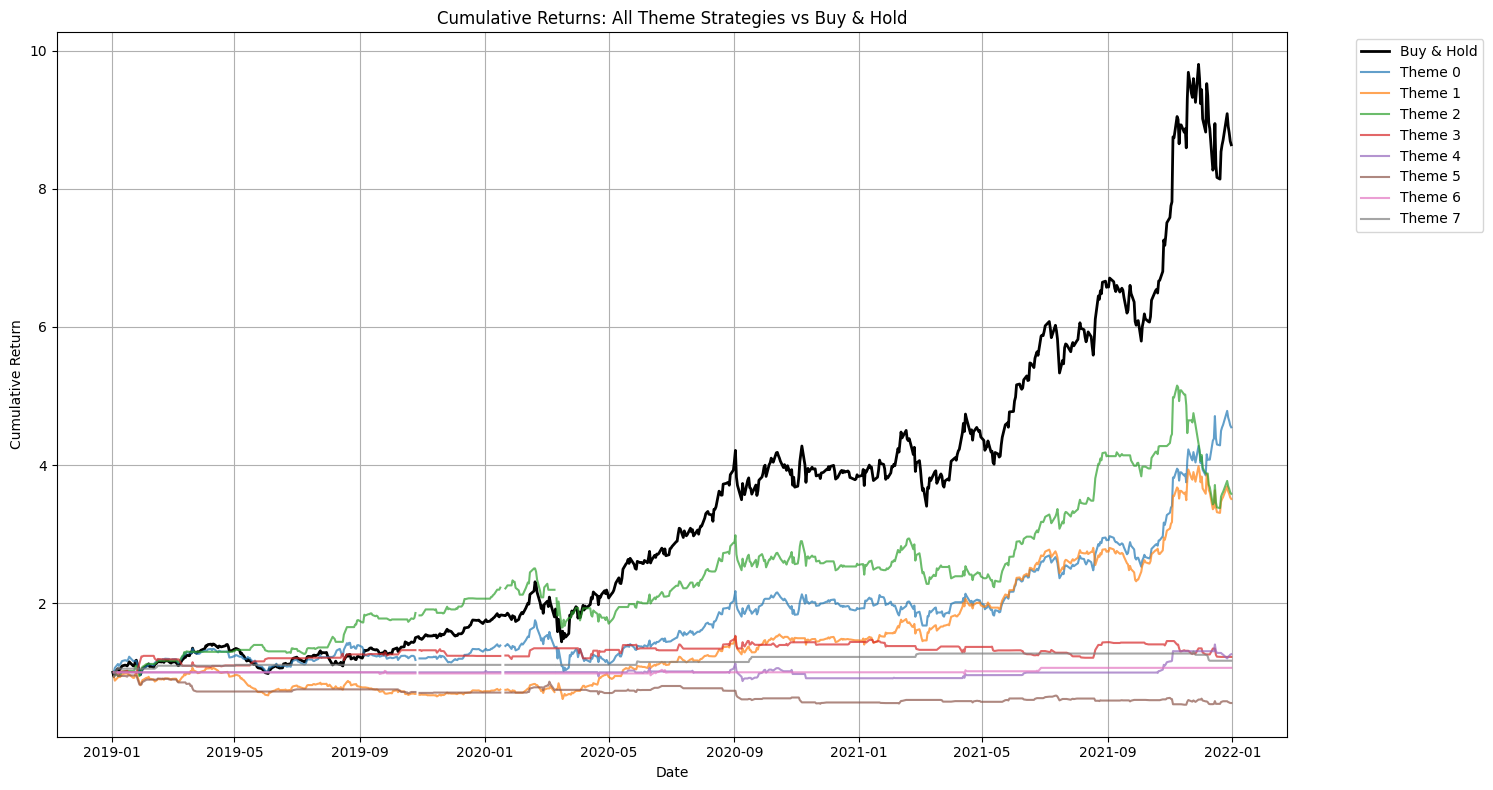


各主题策略最终收益:
Theme 0: 354.72%
Theme 1: 250.97%
Theme 2: 258.37%
Theme 3: 22.31%
Theme 4: 26.24%
Theme 5: -44.43%
Theme 6: 6.48%
Theme 7: 16.77%
Buy & Hold: 763.63%


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. 读取数据
df['Date'] = pd.to_datetime(df['Date'])
daily_theme_sentiment = df.groupby(['Date', 'topic'])['sentiment_score'].mean().unstack()

# 2. 读取价格数据
price_df = pd.read_csv('../2_data/sentiment_price_vix_inner_aligned.csv')
price_df['Date'] = pd.to_datetime(price_df['index'])
price_df = price_df.set_index('Date')

# 3. 计算所有主题的累计收益
plt.figure(figsize=(15, 8))

# 先画buy & hold的收益
returns = price_df['nvda_close'].pct_change().fillna(0)
cum_returns = (1 + returns).cumprod()
plt.plot(cum_returns.index, cum_returns, label='Buy & Hold', color='black', linewidth=2)

# 计算每个主题的策略收益
for theme in range(8):  # 0-7个主题
    # 生成信号
    signal = daily_theme_sentiment[theme].rolling(3, min_periods=1).mean()
    position = (signal > 0.02).astype(int) - (signal < -0.02).astype(int)
    
    # 对齐数据并计算收益
    strategy_data = pd.DataFrame({'position': position})
    strategy_data = pd.merge(
        strategy_data,
        price_df[['nvda_close']],
        left_index=True,
        right_index=True,
        how='inner'
    )
    
    # 计算策略收益
    strategy_returns = strategy_data['position'].shift(1) * returns
    cum_strategy_returns = (1 + strategy_returns).cumprod()
    
    # 画图
    plt.plot(cum_strategy_returns.index, cum_strategy_returns, label=f'Theme {theme}', alpha=0.7)

plt.title('Cumulative Returns: All Theme Strategies vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# 打印各个策略的最终收益
print("\n各主题策略最终收益:")
for theme in range(8):
    signal = daily_theme_sentiment[theme].rolling(3, min_periods=1).mean()
    position = (signal > 0.02).astype(int) - (signal < -0.02).astype(int)
    strategy_data = pd.DataFrame({'position': position})
    strategy_data = pd.merge(
        strategy_data,
        price_df[['nvda_close']],
        left_index=True,
        right_index=True,
        how='inner'
    )
    strategy_returns = strategy_data['position'].shift(1) * returns
    final_return = (1 + strategy_returns).prod() - 1
    print(f"Theme {theme}: {final_return:.2%}")
print(f"Buy & Hold: {cum_returns[-1]-1:.2%}")